In [89]:
import matplotlib.pyplot as plt
import math
import mne
import numpy as np
import pandas as pd
import scipy.io
import scipy.stats as stats
from scipy import signal
from scipy.signal import find_peaks
from sklearn.decomposition import FastICA, PCA

mne.set_log_level('WARNING')

### Datos EEG

In [2]:
# Levantamos los datos puros de EEG
mat = scipy.io.loadmat('/Users/mtobar/Downloads/p300-subject-21.mat')


In [3]:
# Creamos la matriz de datos, data points vs canales. 8 canales. Frecuencia de sampleo 250 Hz.
ch_names=['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
signals = pd.DataFrame(mat['data'][0][0][0], columns = ch_names)

print('Estructura de la informacion:')
signals.head()

Estructura de la informacion:


,Fz,Cz,P3,Pz,P4,PO7,PO8,Oz
0,6.345741,-2.826574,-5.547622,-5.109540,-5.427902,-12.828733,-4.893288,-14.013107
1,4.809175,-3.559781,-5.954600,-5.624037,-5.395182,-13.225392,-4.314703,-13.918633
2,3.342962,-4.131262,-6.127074,-6.003478,-5.354580,-13.390471,-3.828379,-13.966416
3,2.401950,-4.493604,-6.068698,-6.158555,-5.327750,-12.954785,-3.475107,-13.881251
4,2.095043,-4.747584,-6.044509,-6.233059,-5.398479,-11.987429,-3.357387,-13.582345


In [4]:
signals.shape

(355872, 8)

In [5]:
def structure(data):
    for i in data:
        print('Estructura '+ i +': ')

        plt.plot(data[i])
        plt.show()

Estructura Fz: 


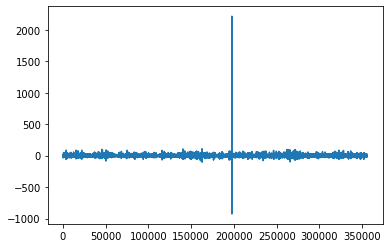

Estructura Cz: 


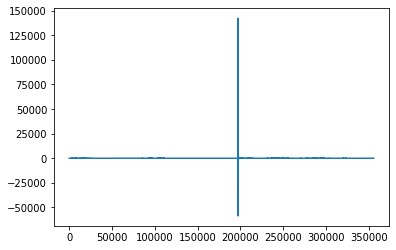

Estructura P3: 


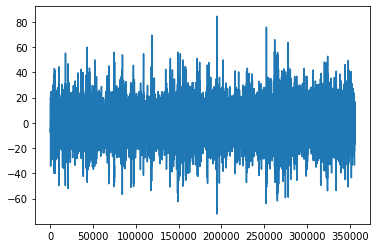

Estructura Pz: 


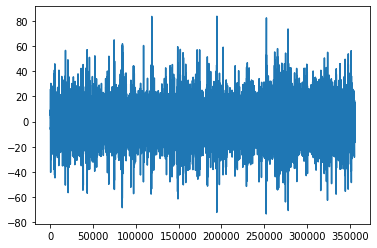

Estructura P4: 


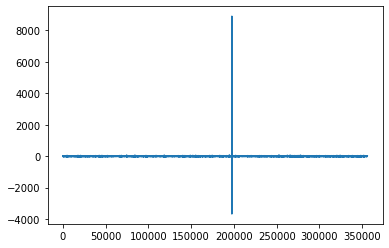

Estructura PO7: 


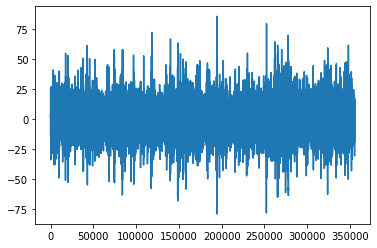

Estructura PO8: 


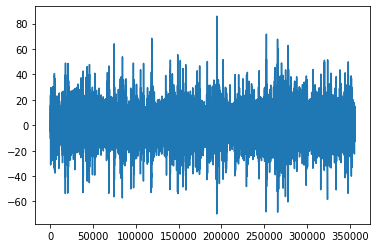

Estructura Oz: 


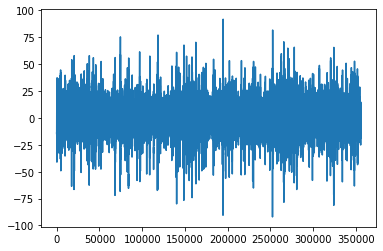

In [6]:
structure(signals)

### Datos Pestañeos

In [7]:
# Levantamos los datos de pestañeos. Canal único. Frecuencia de sampleo 128 Hz.
blinks = pd.read_csv('/Users/mtobar/python-scientific/data/blinking.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

print('Estructura de la informacion:')
blinks.head()

Estructura de la informacion:


,timestamp,counter,eeg,attention,meditation,blinking
0,1.568384e+09,81,21,0,0,0
1,1.568384e+09,82,20,0,0,0
2,1.568384e+09,83,20,0,0,0
3,1.568384e+09,84,22,0,0,0
4,1.568384e+09,85,22,0,0,0


In [8]:
data = blinks.values
eeg = data[:,2]

Estructura Pestañeos:


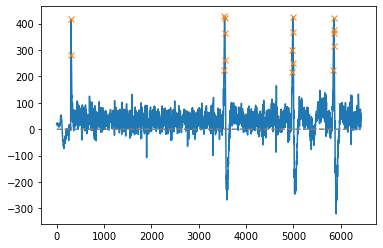

In [9]:
# Análisis de pestañeos

print('Estructura Pestañeos:')
peaks, _ = find_peaks(eeg, height=200)
plt.plot(eeg)
plt.plot(peaks, eeg[peaks], "x")
plt.plot(np.zeros_like(eeg), "--", color="gray")
plt.show()

Pestañeo 1:


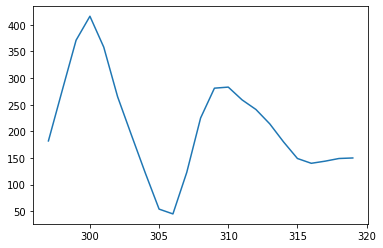

In [10]:
print('Pestañeo 1:')

event_1 = blinks[297:320]
event_1_data = event_1['eeg']
plt.plot(event_1_data)
plt.show()

Pestañeo 2:


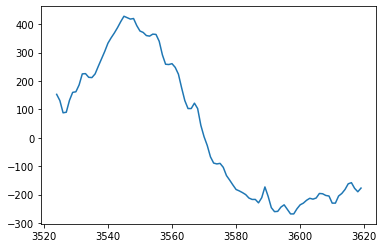

In [11]:
print('Pestañeo 2:')

event_2 = blinks[3524:3620]
event_2_data = event_2['eeg']
plt.plot(event_2_data)
plt.show()

Pestañeo 3:


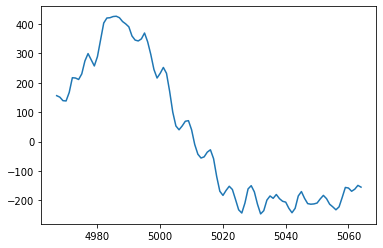

In [12]:
print('Pestañeo 3:')

event_3 = blinks[4967:5065]
event_3_data = event_3['eeg']
plt.plot(event_3_data)
plt.show()

Pestañeo 4:


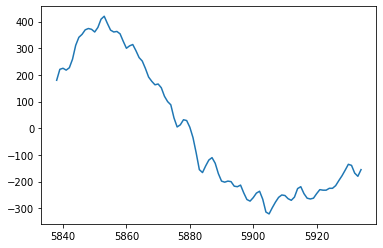

In [13]:
print('Pestañeo 4:')

event_4 = blinks[5838:5935]
event_4_data = event_4['eeg']
plt.plot(event_4_data)
plt.show()

### Ponderación Pestañeos en Canales

El pestañeo afecta con mayor peso a los canales 1 y 2, los más cercanos a los ojos, y en los restantes es más débil. 

In [14]:
def weighs(event):
    full_array = []
    new_array = []
    for i in event:
        for j in [1, 1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]:
            new_array.append(i*j)
        full_array.append(new_array)
        new_array = []
    
    return full_array

In [15]:
full_array_event_1 = weighs(event_1_data)

In [16]:
full_array_event_2 = weighs(event_2_data)

In [17]:
full_array_event_3 = weighs(event_3_data)

In [18]:
full_array_event_4 = weighs(event_4_data)

### Upsample Pestañeos

En el dataset de EEG la frecuencia de sampleo es 250 Hz, en el de pestañeos es 128 Hz. Hacer un Upsample de pestañeos a 250 Hz. 

In [19]:
def resample(event):
    resampled_event = scipy.signal.resample(event, round(len(event)/128*250))
    
    return resampled_event

In [20]:
resampled_event_1 = resample(full_array_event_1)

In [21]:
resampled_event_2 = resample(full_array_event_2)

In [22]:
resampled_event_3 = resample(full_array_event_3)

In [23]:
resampled_event_4 = resample(full_array_event_4)

### Media Zero Pestañeos

Calcular la media de cada pestañeo, en el tiempo por canal y restársela al valor del pestañeo, para que le quede media cero.

In [24]:
def zero_media(event):
    full_array = []
    new_array = []
    for i in event:
        media = i.mean()
        for j in i:
            new_array.append(j - media)
        full_array.append(new_array)
        new_array = []
    
    return full_array

In [25]:
final_event_1 = zero_media(resampled_event_1)

In [26]:
final_event_2 = zero_media(resampled_event_2)

In [27]:
final_event_3 = zero_media(resampled_event_3)

In [28]:
final_event_4 = zero_media(resampled_event_4)

### Factor Gaussiano Pestañeos
 
Creo un vector de factores obtenidos de una curva gaussiana, que tenga el máximo justo en la mitad del pestañeo. De esta manera, se insertará el pestañeo en la curva dentro del EEG, sin generar excesivas discontinuidades.

In [29]:
mu = 0
variance = 1
sigma = math.sqrt(variance)

def factor_normal(evento):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(evento))
    factor = stats.norm.pdf(x, mu, sigma)
    return factor

In [30]:
factor_1 = factor_normal(final_event_1)

In [31]:
factor_2 = factor_normal(final_event_2)

In [32]:
factor_3 = factor_normal(final_event_3)

In [33]:
factor_4 = factor_normal(final_event_4)

### Vector Inserción Pestañeos

Determina el momento de EEG donde se insertará el pestañeo y lo registra en una variable.

In [34]:
def blink_creator():
    inyection = pd.DataFrame(columns=['blink_type'])
    #Itero hasta llegar al tamaño del dataframe signals 355872
    while len(inyection) <= len(signals):
        #Inserto al inyection una cantidad random de ceros entre 2000 y 3000 (pausa entre pestañeos 8 a 12 segundos)
        pause = pd.DataFrame(np.random.randint(low=0, high=1, size=(np.random.randint(low=2000, high=3000))), columns=['blink_type'])
        inyection = inyection.append(pause, ignore_index = True)
        #Obtengo un número de pestañeo al azar para isertar.
        blink_number = np.random.randint(low=1, high=5)
        #Inserto al dataset el número del pestañeo (1, 2, 3, 4), tantas veces como len(pestañeo)
        blink = pd.DataFrame(np.random.randint(low=blink_number, high=blink_number+1, size=(len(globals()[(f"final_event_{blink_number}")]))), columns=['blink_type'])
        inyection = inyection.append(blink, ignore_index = True) 
    
    return (inyection[0:355872])


In [35]:
blink_creator = blink_creator()


In [43]:
blink_creator['blink_type'].astype(str).astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
355867    0
355868    0
355869    0
355870    0
355871    0
Name: blink_type, Length: 355872, dtype: int64

In [84]:
signals_blink_type = pd.concat([signals, blink_creator], axis=1)

In [85]:
signals_data = signals_blink_type.values

### Inyección Pestañeos en EEG

Suma convexa del valor de la señal original con el pestañeo, multiplicando a cada valor original por uno menos el factor gaussiano y a cada valor del pestañeo por el factor gaussiano.

In [334]:
def blink_inyection(EEG_pure_data):
    new_data = []
    size_blink = -1
    for iteration in range(0, len(EEG_pure_data)):
        new_array = []
        blink_type = signals_data[iteration][-1]
        array = signals_data[iteration][0:8]
        if blink_type == 0:
            new_array = list(array)
            size_blink = -1
        else:
            size_blink += 1
            if size_blink >= len(globals()[(f"final_event_{blink_type}")]):
                size_blink = 0
            channel = 0
            for j in array:
                new_array.append(j * (1 - globals()[(f"factor_{blink_type}")][size_blink]) + (globals()[(f"factor_{blink_type}")][size_blink] * globals()[(f"final_event_{blink_type}")][size_blink][channel]))
                channel += 1
        new_data.append(new_array)
        new_array = []
        
    return np.array(new_data)

In [336]:
ch_names=['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
modified_EEG = pd.DataFrame(blink_inyection(signals_data), columns = ch_names)


In [347]:
from datetime import datetime

modified_EEG.to_csv(datetime.now().strftime('modified_EEG_%Y%m%d_%H%M.csv'), index = False)
blink_creator.to_csv(datetime.now().strftime('blinks_%Y%m%d_%H%M.csv'), index = False)